# b-tagging Machine Learning Tutorial
## Sample preparation

The starting point for the trainig are FTAG1 derivations. In this tutorial, MC16d PFlow will be used
* mc16_13TeV.410470.PhPy8EG_A14_ttbar_hdamp258p75_nonallhad.deriv.DAOD_FTAG1.e6337_s3126_r10201_p3703
* mc16_13TeV.427081.Pythia8EvtGen_A14NNPDF23LO_flatpT_Zprime_Extended.deriv.DAOD_FTAG1.e6928_e5984_s3126_r10201_p3703

For machine learning purposes it is not practical to deal with ROOT files ([uproot](https://uproot.readthedocs.io/en/latest/) is a nice tool to read ROOT files and transform them into numpy/pandas arrays).
For b-tagging ML purposes there is the [training-dataset-dumper](https://uproot.readthedocs.io/en/latest/) available to dump ntuples directly from FTAG1 derivations into the [HDF5](https://www.hdfgroup.org/solutions/hdf5/) format.

In our workflow we will use the [training-dataset-dumper](https://uproot.readthedocs.io/en/latest/) to produce HDF5 ntuples from the derivations mentioned above. For this step please follow the instruction in the [`README.md`](https://gitlab.cern.ch/atlas-flavor-tagging-tools/training-dataset-dumper/blob/master/README.md) and use the [`EMPFlow_IPRNN.json`](https://gitlab.cern.ch/atlas-flavor-tagging-tools/training-dataset-dumper/blob/master/configs/single-b-tag/EMPFlow_IPRNN.json) config-file which contains the latest RNNIP and SMT taggers.

This step will take a while to run on the GRID. The HDF5 ntuples are available via RUCIO here:

* user.mguth.410470.btagTraining.e6337_s3126_r10201_p3703.EMPFlow_IPRNN.2019-03-22-T001315-R12455_output.h5
* user.mguth.427081.btagTraining.e6928_e5984_s3126_r10201_p3703.EMPFlow_IPRNN.2019-03-26-T120119-R15298_output.h5

The next step is to merge all those files which can be done with the [`create_hybrid.py`](https://gitlab.cern.ch/atlas-flavor-tagging-tools/training-dataset-dumper/blob/master/create_hybrid.py) script.
It is possible to chose the number of jets which should be merged as well as some cuts which are used for the hybrid sample creation. There are several useful flags 
```
'-c', '--ttbarcomp': output composition fraction for ttbar jets, from 0 to 1
'--no_cut': no hybrid cuts are applied (pt<250 GeV for ttbar and pT>250 for Z')
'--write_tracks': beside jets also tracks are written
'--even': selects only jets with EVEN eventNumber
'--odd': : selects only jets with ODD eventNumber
'--bjets': selects only b-labeled jets
'--cjets': selects only c-labeled jets
'--ujets': selects only light-labeled jets

```
Our convention is to use for the training always jets with even event numbers and for testing and validation jets with odd event numbers in order to not mix testing and training jets.

For the latest DL1 training the workflow was to write out different file for each jet category (light, c, b) with the same amount of jets for ttbar. For Z' it doesn't make a difference since the flavour fractions are already ~1/3.

This yields to a set of training and validation/testing samples:

Training files:
* MC16d_hybrid-ext_even_0_PFlow-pTcuts-tutorial-file_merged.h5 (extended Z' sample with hybrid cuts)  
* MC16d_hybrid_even_100_PFlow-pTcuts-ujets-tutorial-file_merged.h5 (light flavour jets from ttbar sample)
* MC16d_hybrid_even_100_PFlow-pTcuts-cjets-tutorial-file_merged.h5 (c-jets from ttbar sample)
* MC16d_hybrid_even_100_PFlow-pTcuts-bjets-tutorial-file_merged.h5 (b-jets from ttbar sample)

Validation/testing samples:
* MC16d_hybrid_odd_100_PFlow-no_pTcuts-tutorial-file_merged.h5
* MC16d_hybrid-ext_odd_0_PFlow-no_pTcuts-tutorial-file_merged.h5

You can find those prepared samples here: `/eos/user/m/mguth/public/btagging-ml_tutorial`

The next step is the creation of the hybrid sample by merging the trainng samples (even event numbers) in the correct manner.

In [1]:
# importing necessary packages
import h5py
import numpy as np
from numpy.lib.recfunctions import repack_fields
import pandas as pd
import json
from keras.utils import np_utils

Using TensorFlow backend.


![alt text](img/downsampling.png)
First we define the downsampling of the samples. The principle is shown in the image above. In each pT and |eta| bin the same amount of jets are inserted for each flavour category (light, c- and b-jets). This is an alternative approach to re-weighting the pT and |eta| distributions in order to keep the training weights to 1.

In [2]:
def DownSampling(bjets, cjets, ujets):
    # pT in MeV
    pt_bins = np.concatenate((np.linspace(0, 600000, 351),
                              np.linspace(650000, 6000000, 84)))
    eta_bins = np.linspace(0, 2.5, 10)

    histvals_b, _, _ = np.histogram2d(bjets['abs_eta_uncalib'], bjets['pt_uncalib'],
                                [eta_bins, pt_bins])
    histvals_c, _, _ = np.histogram2d(cjets['abs_eta_uncalib'], cjets['pt_uncalib'],
                                [eta_bins, pt_bins])
    histvals_u, _, _ = np.histogram2d(ujets['abs_eta_uncalib'], ujets['pt_uncalib'],
                                [eta_bins, pt_bins])

    b_locations_pt = np.digitize(bjets['pt_uncalib'], pt_bins) - 1
    b_locations_eta = np.digitize(bjets['abs_eta_uncalib'], eta_bins) - 1
    b_locations = zip(b_locations_pt, b_locations_eta)
    b_locations = list(b_locations)

    c_locations_pt = np.digitize(cjets['pt_uncalib'], pt_bins) - 1
    c_locations_eta = np.digitize(cjets['abs_eta_uncalib'], eta_bins) - 1
    c_locations = zip(c_locations_pt, c_locations_eta)
    c_locations = list(c_locations)

    u_locations_pt = np.digitize(ujets['pt_uncalib'], pt_bins) - 1
    u_locations_eta = np.digitize(ujets['abs_eta_uncalib'], eta_bins) - 1
    u_locations = zip(u_locations_pt, u_locations_eta)
    u_locations = list(u_locations)

    c_loc_indices = { (pti, etai) : [] for pti,_ in enumerate(pt_bins[::-1]) for etai,_ in enumerate(eta_bins[::-1])}
    b_loc_indices = { (pti, etai) : [] for pti,_ in enumerate(pt_bins[::-1]) for etai,_ in enumerate(eta_bins[::-1])}
    u_loc_indices = { (pti, etai) : [] for pti,_ in enumerate(pt_bins[::-1]) for etai,_ in enumerate(eta_bins[::-1])}
    print('Grouping the bins')
    for i, x in enumerate(c_locations):
        c_loc_indices[x].append(i)

    for i, x in enumerate(b_locations):
        b_loc_indices[x].append(i)

    for i, x in enumerate(u_locations):
        u_loc_indices[x].append(i)

    cjet_indices = []
    bjet_indices = []
    ujet_indices = []
    print('Matching the bins for all flavours')
    for pt_bin_i in range(len(pt_bins) - 1):
        for eta_bin_i in range(len(eta_bins) - 1):
            loc = (pt_bin_i, eta_bin_i)

            nbjets = int(histvals_b[eta_bin_i][pt_bin_i])
            ncjets = int(histvals_c[eta_bin_i][pt_bin_i])
            nujets = int(histvals_u[eta_bin_i][pt_bin_i])

            njets = min([nbjets, ncjets, nujets])
            c_indices_for_bin = c_loc_indices[loc][0:njets]
            b_indices_for_bin = b_loc_indices[loc][0:njets]
            u_indices_for_bin = u_loc_indices[loc][0:njets]
            cjet_indices += c_indices_for_bin
            bjet_indices += b_indices_for_bin
            ujet_indices += u_indices_for_bin

    cjet_indices.sort()
    bjet_indices.sort()
    ujet_indices.sort()
    return np.array(bjet_indices), np.array(cjet_indices), np.array(ujet_indices)

First the hybrid composition is defined by 65% ttbar and 35% Z' jets. Due to the different $p_T$ distributions of the b-, c-, and light flavour jets, we need a factor 2-3 more c- and light flavour jets as input for the downsampling.

In [3]:
Njets = 50000 #500000 # reduced number of jets such that it runs faster you can also use more
nZ = int(Njets*3*(1/0.65-1))
ncjets = int(2.3 * Njets)
nujets = int(2.7 * Njets)

Please change the diretory to your path where you have the files stored

In [4]:
file_path = "/eos/user/m/mguth/public/btagging-ml_tutorial_files"

In [5]:
Zprime_file = file_path + "/MC16d_hybrid-ext_even_0_PFlow-pTcuts-tutorial-file_merged.h5"
ttbar_files = file_path + "/MC16d_hybrid_even_100_PFlow-pTcuts-{}jets-tutorial-file_merged.h5"

df_Zprime = h5py.File(Zprime_file, "r")['jets'][:nZ]
df_tt_u = h5py.File(ttbar_files.format("u"), "r")['jets'][:nujets]
df_tt_c = h5py.File(ttbar_files.format("c"), "r")['jets'][:ncjets]
df_tt_b = h5py.File(ttbar_files.format("b"), "r")['jets'][:Njets]

tnp_Zprime = np.asarray(h5py.File(Zprime_file, "r")['tracks'][:nZ])
tnp_tt_u = np.asarray(h5py.File(ttbar_files.format("u"), "r")['tracks'][:nujets])
tnp_tt_c = np.asarray(h5py.File(ttbar_files.format("c"), "r")['tracks'][:ncjets])
tnp_tt_b = np.asarray(h5py.File(ttbar_files.format("b"), "r")['tracks'][:Njets])


In [6]:
import matplotlib.pyplot as plt

binning = {"pt_uncalib": np.linspace(10000, 6000000, 600),#/1000,
               "abs_eta_uncalib": np.linspace(0, 2.5, 26)}
var = "pt_uncalib"
plt.hist(df_tt_b[var]/1000, binning[var]/1000, histtype='step',
         label=["ttbar - b-jets"],
         stacked=False, 
         fill=False, 
         linewidth=2, alpha=0.8)
plt.hist(df_Zprime[df_Zprime['HadronConeExclTruthLabelID']==5][var]/1000, binning[var]/1000, histtype='step',
         label=["Z' - b-jets"], 
         stacked=False, 
         fill=False, 
         linewidth=2, alpha=0.8)
plt.hist(np.concatenate([df_Zprime[df_Zprime['HadronConeExclTruthLabelID']==5][var]/1000, df_tt_b[var]/1000]), binning[var]/1000, histtype='step',
         label=["combined - b-jets"],
         stacked=False, 
         fill=False,
         linewidth=2, alpha=0.8)
plt.hist(np.concatenate([df_Zprime[df_Zprime['HadronConeExclTruthLabelID']==4][var]/1000, df_tt_c[var]/1000]), binning[var]/1000, histtype='step',
         label=["combined - c-jets"],
         stacked=False, 
         fill=False,
         linewidth=2, alpha=0.8)
plt.xlabel('$p_T$ [GeV]',fontsize=12)
plt.ylabel('# jets',fontsize=12)
plt.yscale('log')
plt.legend()

In [7]:
bjets = np.concatenate([df_Zprime[df_Zprime['HadronConeExclTruthLabelID']==5], df_tt_b])
cjets = np.concatenate([df_Zprime[df_Zprime['HadronConeExclTruthLabelID']==4], df_tt_c])
ujets = np.concatenate([df_Zprime[df_Zprime['HadronConeExclTruthLabelID']==0], df_tt_u])

btrks = np.concatenate([tnp_Zprime[df_Zprime['HadronConeExclTruthLabelID']==5], tnp_tt_b])
ctrks = np.concatenate([tnp_Zprime[df_Zprime['HadronConeExclTruthLabelID']==4], tnp_tt_c])
utrks = np.concatenate([tnp_Zprime[df_Zprime['HadronConeExclTruthLabelID']==0], tnp_tt_u])

bjet_indices, cjet_indices, ujet_indices = DownSampling(bjets, cjets, ujets)

Grouping the bins
Matching the bins for all flavours


In [8]:
bjets = bjets[bjet_indices]
cjets = cjets[cjet_indices]
ujets = ujets[ujet_indices]

btrks = btrks[bjet_indices]
ctrks = ctrks[cjet_indices]
utrks = utrks[ujet_indices]

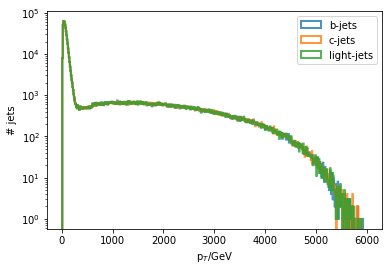

In [9]:
plt.hist(bjets[var]/1000, binning[var]/1000, histtype='step',
         label=["b-jets"],
         stacked=False, 
         fill=False, 
         linewidth=2, alpha=0.8)
plt.hist(cjets[var]/1000, binning[var]/1000, histtype='step',
         label=["c-jets"], 
         stacked=False, 
         fill=False, 
         linewidth=2, alpha=0.8)
plt.hist(ujets[var]/1000, binning[var]/1000, histtype='step',
         label=["light-jets"],
         stacked=False, 
         fill=False,
         linewidth=2, alpha=0.8)
plt.xlabel('p$_T$/GeV')
plt.ylabel('# jets')
plt.yscale('log')
plt.legend()

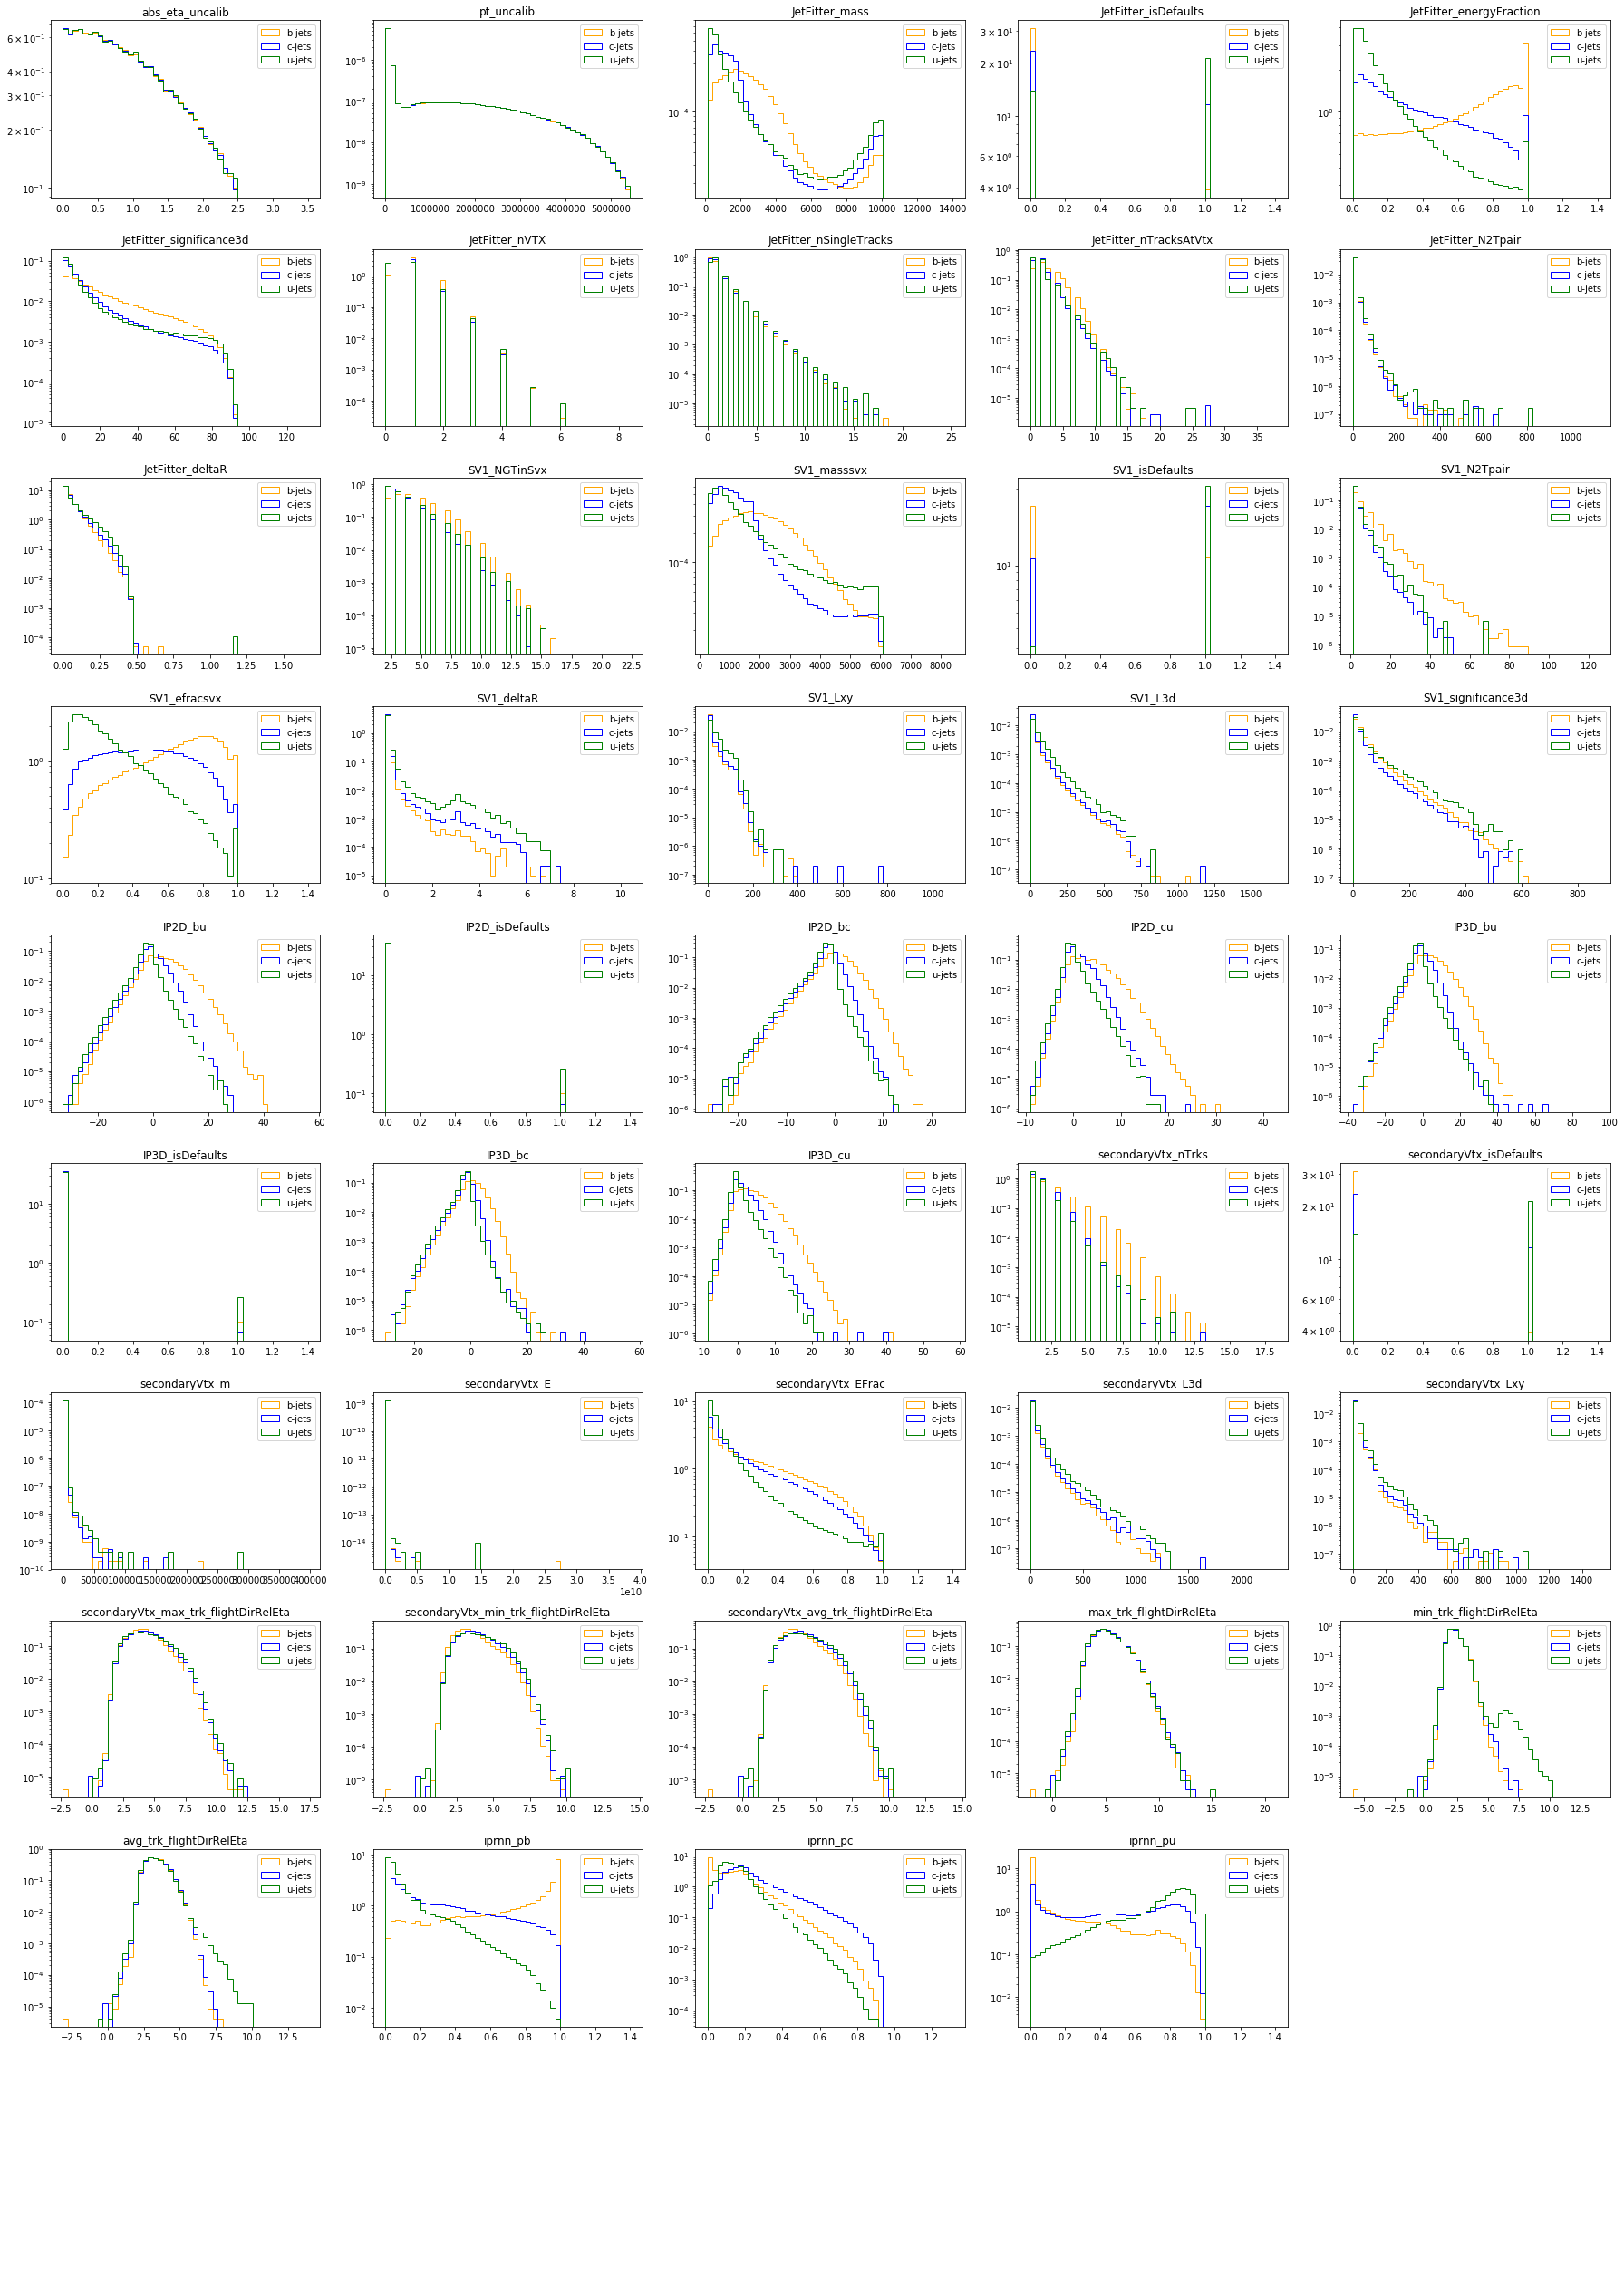

In [10]:
fig, ax = plt.subplots(10, 5, figsize=(25, 35))
nbins = 50

with open("DL1r_Variables.json") as vardict:
    variablelist = json.load(vardict)[:]
variablelist.remove("HadronConeExclTruthLabelID")
varcounter = -1
for i, axobjlist in enumerate(ax):
      for j, axobj in enumerate(axobjlist):
        varcounter+=1
        if varcounter < len(variablelist):
            var = variablelist[varcounter]
        
            b = pd.DataFrame({var: bjets[var]})
            c = pd.DataFrame({var: cjets[var]})
            u = pd.DataFrame({var: ujets[var]})
            b.replace([np.inf, -np.inf], np.nan, inplace=True)
            c.replace([np.inf, -np.inf], np.nan, inplace=True)
            u.replace([np.inf, -np.inf], np.nan, inplace=True)
    
            b = b.dropna()
            c = c.dropna()
            u = u.dropna()

            
            minval = np.amin(b[var])
            if 'pt' in var:
                maxval = np.percentile(u[var],99.99)
            else:
                maxval = max([np.amax(u[var]), np.amax(c[var]), np.amax(b[var])])*1.4
            binning = np.linspace(minval,maxval,nbins)


            axobj.hist(b[var],binning,histtype=u'step', color='orange',label='b-jets',density=1)
            axobj.hist(c[var],binning,histtype=u'step', color='b',label='c-jets',density=1)
            axobj.hist(u[var],binning,histtype=u'step', color='g',label='u-jets',density=1)

            
            axobj.legend()
            axobj.set_yscale('log',nonposy='clip')
            axobj.set_title(variablelist[varcounter])

        else:
            axobj.axis('off')

plt.tight_layout()
# plt.savefig("DL1r-variables.pdf", transparent=True)
plt.show()

In [11]:
def Gen_default_dict(scale_dict):
    """Generates default value dictionary from scale/shift dictionary."""
    default_dict = {}
    for elem in scale_dict:
        if 'isDefaults' in elem['name']:
            continue
        default_dict[elem['name']] = elem['default']
    return default_dict

In [12]:
with open("DL1r_Variables.json") as vardict:
    var_names = json.load(vardict)[:]
def ScaleVariables(bjets, cjets, ujets):
    with open("params_MC16D-ext_2018-PFlow_70-8M_mu.json", 'r') as infile:
        scale_dict = json.load(infile)
    bjets = pd.DataFrame(bjets)
    cjets = pd.DataFrame(cjets)
    ujets = pd.DataFrame(ujets)
    bjets.replace([np.inf, -np.inf], np.nan, inplace=True)
    cjets.replace([np.inf, -np.inf], np.nan, inplace=True)
    ujets.replace([np.inf, -np.inf], np.nan, inplace=True)
    # Replace NaN values with default values from default dictionary
    default_dict = Gen_default_dict(scale_dict)
    bjets.fillna(default_dict, inplace=True)
    cjets.fillna(default_dict, inplace=True)
    ujets.fillna(default_dict, inplace=True)
    # scale and shift distribution
    for elem in scale_dict:
        if 'isDefaults' in elem['name']:
            continue
        if elem['name'] not in var_names:
            continue
        else:
            bjets[elem['name']] = ((bjets[elem['name']] - elem['shift']) /
                                  elem['scale'])
            cjets[elem['name']] = ((cjets[elem['name']] - elem['shift']) /
                                  elem['scale'])
            ujets[elem['name']] = ((ujets[elem['name']] - elem['shift']) /
                                  elem['scale'])
    return bjets.to_records(index=False), cjets.to_records(index=False), ujets.to_records(index=False)

In [13]:
bjets_scaled, cjets_scaled, ujets_scaled = ScaleVariables(bjets, cjets, ujets)

Also, scale the track variables. Here we just have to be careful not to include the masked values in the calculation of the mean and variance.




In [14]:
def scale(data, var_names, savevars, filename='trkScale.json', mask_value=0):
    '''
    Args:
    -----
        data: a numpy array of shape (nJets, nTrks, nFeatures)
        var_names: list of keys to be used for the model
        savevars: bool -- True for training, False for testing
                  it decides whether we want to fit on data to find mean and std
                  or if we want to use those stored in the json file
        VAR_FILE: string: Where to save the output
        mask_value: the value to mask when taking the avg and stdev

    Returns:
    --------
        modifies data in place, writes out scaling dictionary

    Reference: https://github.com/mickypaganini/RNNIP/blob/master/dataprocessing.py#L235-L319
    '''
    import json

    scale = {}

    # Track variables
    # data has shape nJets,nTrks,nFeatures,so to sort out the mask,
    # we need to find where the value is masked for a track over
    # all it's features
    # mask has shape nJets,nTrks
    mask = ~ np.all(data == mask_value, axis=-1)

    if savevars:

        for v, name in enumerate(var_names):
            print('Scaling feature {} of {} ({}).'.format(v + 1, len(var_names), name))
            f = data[:, :, v]
            slc = f[mask]
            m, s = slc.mean(), slc.std()
            slc -= m
            slc /= s
            data[:, :, v][mask] = slc.astype('float32')
            scale[name] = {'mean' : float(m), 'sd' : float(s)}

        with open(filename, 'w') as varfile:
            json.dump(scale, varfile)

    else:
        with open(filename, 'r') as varfile:
            varinfo = json.load(varfile)

        for v, name in enumerate(var_names):
            print('Scaling feature {} of {} ({}).'.format(v + 1, len(var_names), name))
            f = data[:, :, v]
            slc = f[mask]
            m = varinfo[name]['mean']
            s = varinfo[name]['sd']
            slc -= m
            slc /= s
            data[:, :, v][mask] = slc.astype('float32')

We don't need all the variables that the training dataset dumper prints out. Variables that are natually close to or centered around 0 we don't scale.

Furthermore, for some of the variables that follow a power law spectrum ($p_T^{frac}$ and $\Delta R$), we take the log of to make them more Gaussian like before transforming.

In [15]:
noNormVars = ['IP3D_signed_d0_significance','IP3D_signed_z0_significance',
              'numberOfInnermostPixelLayerHits',
              'numberOfNextToInnermostPixelLayerHits',
              'numberOfInnermostPixelLayerSharedHits',
              'numberOfInnermostPixelLayerSplitHits',
              'numberOfPixelSharedHits',
              'numberOfPixelSplitHits',
              'numberOfSCTSharedHits']
logNormVars = ['ptfrac', 'dr']
jointNormVars = ['numberOfPixelHits','numberOfSCTHits',]

trkVars = noNormVars + logNormVars + jointNormVars

In [16]:
trks = np.concatenate((utrks, ctrks, btrks))

X_trk_train = np.stack([np.nan_to_num(trks[v] )for v in trkVars],axis=-1)

mask = ~ np.all(X_trk_train == 0, axis=-1)

eps = 1e-8

# Take the log of the desired variables
for i, v in enumerate(logNormVars):
    j = i + len(noNormVars)
    X_trk_train[:,:,j][mask] = np.log(X_trk_train[:,:,j][mask] + eps)
    
scale(X_trk_train[:,:,len(noNormVars):], logNormVars+jointNormVars, savevars=True)

Scaling feature 1 of 4 (ptfrac).
Scaling feature 2 of 4 (dr).
Scaling feature 3 of 4 (numberOfPixelHits).
Scaling feature 4 of 4 (numberOfSCTHits).


In [17]:
if 'HadronConeExclTruthLabelID' in var_names:
    var_names.remove('HadronConeExclTruthLabelID')
print('concatenating flavour samples')
X_train = np.concatenate((ujets_scaled, cjets_scaled, bjets_scaled))
y_train = np.concatenate((np.zeros(len(ujets_scaled)),
                          np.ones(len(cjets_scaled)),
                          2 * np.ones(len(bjets_scaled))))

Y_train = np_utils.to_categorical(y_train, 3)
X_train = repack_fields(X_train[var_names])
X_train = X_train.view(np.float64).reshape(X_train.shape + (-1,))
print(X_train.shape)
rng_state = np.random.get_state()
# shuffle the arrays
print('shuffle arrays')
np.random.shuffle(X_train)
np.random.set_state(rng_state)
np.random.shuffle(X_trk_train)
np.random.set_state(rng_state)
np.random.shuffle(Y_train)
assert X_train.shape[1] == len(var_names)


concatenating flavour samples
(2072727, 44)
shuffle arrays


In [18]:
# outfile_name = file_path+"/MC16d_hybrid-training_sample-NN.h5"
outfile_name = "./MC16d_hybrid-training_sample-NN.h5"
h5f = h5py.File(outfile_name, 'w')
h5f.create_dataset('X_train', data=X_train, compression='gzip')
h5f.create_dataset('X_trk_train', data=X_trk_train, compression='gzip')
h5f.create_dataset('Y_train', data=Y_train, compression='gzip')
h5f.close()

The same procedure is then repeated for the validation/training sample

In [19]:
def GetTestSample(jets):
    with open("params_MC16D-ext_2018-PFlow_70-8M_mu.json", 'r') as infile:
        scale_dict = json.load(infile)
           
    jets = pd.DataFrame(jets)
    jets.query('HadronConeExclTruthLabelID<=5', inplace=True)
    jets_pt_eta = jets[['pt_uncalib', 'abs_eta_uncalib']]
    labels = jets['HadronConeExclTruthLabelID'].values
    jets = jets[var_names]
    jets.replace([np.inf, -np.inf], np.nan, inplace=True)
    # Replace NaN values with default values from default dictionary
    default_dict = Gen_default_dict(scale_dict)
    jets.fillna(default_dict, inplace=True)
    # scale and shift distribution
    
    for elem in scale_dict:
        if 'isDefaults' in elem['name']:
            continue
        if elem['name'] not in var_names:
            continue
        else:
            jets[elem['name']] = ((jets[elem['name']] - elem['shift']) / elem['scale'])
    labels_cat = np.copy(labels)
    labels_cat[labels_cat==5] = 2
    labels_cat[labels_cat==4] = 1
    labels_cat = np_utils.to_categorical(labels_cat, 3)

    return jets.values, jets_pt_eta.to_records(index=False), labels, labels_cat

In [20]:
ttbar_test = file_path + "/MC16d_hybrid_odd_100_PFlow-no_pTcuts-tutorial-file_merged.h5"
df_tt_test = h5py.File(ttbar_test, "r")['jets'][:]

In [21]:
X_test, jpt, labels, Y_test = GetTestSample(df_tt_test)

/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:4042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  method=method)
/usr/local/lib/python3.5/dist-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [22]:
tnp_tt_test = h5py.File(ttbar_test, "r")['tracks'][:][trkVars]
tnp_tt_test = tnp_tt_test[df_tt_test['HadronConeExclTruthLabelID'] <= 5]

X_trk_test = np.stack([np.nan_to_num(tnp_tt_test[v]) for v in trkVars],axis=-1)

mask = ~ np.all(X_trk_test == 0, axis=-1)

# Take the log of the desired variables
for i, v in enumerate(logNormVars):
    j = i + len(noNormVars)
    X_trk_test[:,:,j][mask] = np.log(X_trk_test[:,:,j][mask] + eps)
    
scale(X_trk_test[:,:,len(noNormVars):], logNormVars+jointNormVars, savevars=False)

Scaling feature 1 of 4 (ptfrac).
Scaling feature 2 of 4 (dr).
Scaling feature 3 of 4 (numberOfPixelHits).
Scaling feature 4 of 4 (numberOfSCTHits).


In [23]:
# outfile_name = file_path+"/MC16d_ttbar-test-validation_sample-NN.h5"
outfile_name = "./MC16d_ttbar-test-validation_sample-NN.h5"
h5f = h5py.File(outfile_name, 'w')
h5f.create_dataset('X_test', data=X_test, compression='gzip')
h5f.create_dataset('X_trk_test', data=X_trk_test, compression='gzip')
h5f.create_dataset('Y_test', data=Y_test, compression='gzip')
h5f.create_dataset('pt_eta', data=jpt, compression='gzip')
h5f.create_dataset('labels', data=labels, compression='gzip')
h5f.close()

In [24]:
Zprime_test = file_path + "/MC16d_hybrid-ext_odd_0_PFlow-no_pTcuts-tutorial-file_merged.h5"
df_Z_test = h5py.File(Zprime_test, "r")['jets'][:]

In [25]:
X_test_Z, jpt_Z, labels_Z, Y_test_Z = GetTestSample(df_Z_test)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [26]:
tnp_Z_test = h5py.File(Zprime_test, "r")['tracks'][:][trkVars]
tnp_Z_test = tnp_Z_test[df_Z_test['HadronConeExclTruthLabelID'] <= 5]

X_trk_test_Z = np.stack([np.nan_to_num(tnp_Z_test[v]) for v in trkVars],axis=-1)

mask = ~ np.all(X_trk_test_Z == 0, axis=-1)

# Take the log of the desired variables
for i, v in enumerate(logNormVars):
    j = i + len(noNormVars)
    X_trk_test_Z[:,:,j][mask] = np.log(X_trk_test_Z[:,:,j][mask] + eps)
    
scale(X_trk_test_Z[:,:,len(noNormVars):], logNormVars+jointNormVars, savevars=False)

Scaling feature 1 of 4 (ptfrac).
Scaling feature 2 of 4 (dr).
Scaling feature 3 of 4 (numberOfPixelHits).
Scaling feature 4 of 4 (numberOfSCTHits).


In [27]:
# outfile_name = file_path+"/MC16d_Zprime-test-validation_sample-NN.h5"
outfile_name = "./MC16d_Zprime-test-validation_sample-NN.h5"
h5f = h5py.File(outfile_name, 'w')
h5f.create_dataset('X_test', data=X_test_Z, compression='gzip')
h5f.create_dataset('X_trk_test', data=X_trk_test_Z, compression='gzip')
h5f.create_dataset('Y_test', data=Y_test_Z, compression='gzip')
h5f.create_dataset('pt_eta', data=jpt_Z, compression='gzip')
h5f.create_dataset('labels', data=labels_Z, compression='gzip')
h5f.close()

## Converting ROOT files
If you have already ROOT files with all the inputs you want to train DIPS/DL1 with you can easily convert the ROOT files to hdf5 using uproot

A dedicated DL1 script to convert ROOT files with uproot can be found [here](https://gitlab.cern.ch/atlas-flavor-tagging-tools/DL1_framework/blob/master/tools/convert_fromROOT.py)